In [1]:
import pandas as pd
import os
import openpyxl
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, chi2
import matplotlib.pyplot as plt
import pyfolio as pf
from scipy.stats import binom
import math
import numpy.matlib as mt
import matplotlib.dates as mdates
import scipy.stats as stats
from sklearn.covariance import LedoitWolf
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
# #Load path
# wd = os.getcwd()
# file = '/Eurostoxx1.xlsx'
# file_path = f"{wd}{file}"
# file_path
# sheet_name = 'Tabelle1'
# # Read the Excel file and skip the first 3 rows and row 5 (row 4 after skipping 3)
# df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=[0, 1, 2, 4])


In [3]:
# # Remove any columns with missing values
# df = df.dropna(axis=1)
# # Convert the first column to datetime format and set it as the index
# df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
# df.set_index(df.columns[0], inplace=True)
# # Filter the data to include only dates between 01.01.2018 and 01.01.2024
# start_date = '2018-01-01'
# end_date = '2024-01-01'
# df = df[(df.index >= start_date) & (df.index <= end_date)]
# # Define the public holidays in Germany from 2018 to 2024
# holidays = [
#     '2018-01-01', '2018-03-30', '2018-04-02', '2018-05-10', '2018-05-21', '2018-10-03', '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-31',
#     '2019-01-01', '2019-04-19', '2019-04-22', '2019-05-30', '2019-06-10', '2019-10-03', '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-31',
#     '2020-01-01', '2020-04-10', '2020-04-13', '2020-05-21', '2020-06-01', '2020-10-03', '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-31',
#     '2021-01-01', '2021-04-02', '2021-04-05', '2021-05-13', '2021-05-24', '2021-10-03', '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-31',
#     '2022-01-01', '2022-04-15', '2022-04-18', '2022-05-26', '2022-06-06', '2022-10-03', '2022-12-24', '2022-12-25', '2022-12-26', '2022-12-31',
#     '2023-01-01', '2023-04-07', '2023-04-10', '2023-05-18', '2023-05-29', '2023-10-03', '2023-12-24', '2023-12-25', '2023-12-26', '2023-12-31',
#     '2024-01-01'
# ]

# # Convert holidays to datetime format and remove them from the DataFrame
# holidays = pd.to_datetime(holidays)
# df = df[~df.index.isin(holidays)]

# Save the cleaned data to a CSV file without row numbers
# output_path = '/Users/minhanhle/Documents/MasterArbeit/MasterArbeitCode/Cleaned_Eurostoxx.csv'
# df.to_csv(output_path, index=True)

In [4]:
df = pd.read_csv('./Cleaned_Eurostoxx.csv')
df.rename(columns={'Name': 'Datum'}, inplace=True)
df.columns = [col.replace(' (~E )', '') for col in df.columns]
df.set_index('Datum', inplace=True)
df.shape

(1517, 564)

In [5]:
# Berechnung der täglichen Rendite
returns = np.log(df/ df.shift(1))
returns.index = df.index
print(returns)

            3I GROUP  A P MOLLER MAERSK B       A2A       AAK  AALBERTS  \
Datum                                                                     
2018-01-02       NaN                  NaN       NaN       NaN       NaN   
2018-01-03  0.000965            -0.005594 -0.003950  0.004250  0.011987   
2018-01-04  0.010552             0.029253  0.035000  0.015152  0.016453   
2018-01-05  0.014212             0.006596  0.014543  0.013278  0.014149   
2018-01-08 -0.018994             0.026556 -0.001256  0.004114  0.004522   
...              ...                  ...       ...       ...       ...   
2023-12-21 -0.001436             0.026599 -0.010152  0.009418 -0.008362   
2023-12-22  0.004303             0.027407 -0.001612  0.007373  0.005835   
2023-12-27  0.006064            -0.047623 -0.004853 -0.002452 -0.000506   
2023-12-28 -0.003563            -0.017155  0.001890  0.006849 -0.004821   
2023-12-29 -0.002859             0.013130  0.002963 -0.015725 -0.001527   

            ABB LTD N  A

In [6]:
# Drop NA
returns = returns.dropna()
#equal weight
equal_weight = np.array([1/len(returns.columns)] * len(returns.columns))
#Wähle Gewichte
weights = equal_weight

#Definiere Sample/Test Set
sampleSize = len(returns)
windowSize = 250
testWindowSize = sampleSize-windowSize
print(testWindowSize,returns.shape)

1266 (1516, 564)


In [7]:
returns.iloc[1515,:]
print(1265+250)

1515


In [8]:
# Berechnen der Korrelation
correlation_matrix = returns.corr()
correlation_matrix

,3I GROUP,A P MOLLER MAERSK B,A2A,AAK,AALBERTS,ABB LTD N,ABN AMRO BANK,ABRDN,ACCIONA,ACCOR,...,WHITBREAD,WIENERBERGER,WIHLBORGS FASTIGHETER,WOLTERS KLUWER,WORLDLINE,WPP,YARA INTERNATIONAL,ZALANDO (XET),ZEALAND PHARMA,ZURICH INSURANCE GROUP
3I GROUP,1.000000,0.358538,0.424203,0.401958,0.615916,0.574779,0.439139,0.655306,0.341662,0.507981,...,0.577682,0.492424,0.445282,0.326337,0.294491,0.580689,0.368338,0.346681,0.228234,0.558097
A P MOLLER MAERSK B,0.358538,1.000000,0.240027,0.253514,0.411876,0.429816,0.298810,0.376870,0.216821,0.320199,...,0.275811,0.348838,0.273055,0.161935,0.200460,0.323437,0.300745,0.240296,0.156527,0.297852
A2A,0.424203,0.240027,1.000000,0.381076,0.417667,0.413466,0.372757,0.411595,0.457849,0.365194,...,0.333055,0.371370,0.409469,0.320860,0.232400,0.370974,0.326434,0.266356,0.230037,0.465635
AAK,0.401958,0.253514,0.381076,1.000000,0.417598,0.450742,0.272030,0.379009,0.323689,0.324041,...,0.304254,0.309707,0.464503,0.385684,0.259720,0.371768,0.342227,0.324417,0.259975,0.388836
AALBERTS,0.615916,0.411876,0.417667,0.417598,1.000000,0.656661,0.530058,0.626466,0.340349,0.549027,...,0.557565,0.578643,0.465840,0.266049,0.367499,0.566760,0.441089,0.421527,0.195802,0.483283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WPP,0.580689,0.323437,0.370974,0.371768,0.566760,0.516643,0.504499,0.567495,0.314463,0.514671,...,0.561933,0.495643,0.362481,0.219509,0.253444,1.000000,0.374281,0.310615,0.177326,0.492073
YARA INTERNATIONAL,0.368338,0.300745,0.326434,0.342227,0.441089,0.465341,0.356689,0.415551,0.284578,0.341566,...,0.321975,0.363545,0.299293,0.220439,0.222377,0.374281,1.000000,0.251794,0.156009,0.427580
ZALANDO (XET),0.346681,0.240296,0.266356,0.324417,0.421527,0.378822,0.231161,0.367104,0.225631,0.261665,...,0.254780,0.351872,0.367991,0.213554,0.310585,0.310615,0.251794,1.000000,0.227427,0.236250
ZEALAND PHARMA,0.228234,0.156527,0.230037,0.259975,0.195802,0.242973,0.120300,0.177937,0.201413,0.185277,...,0.153393,0.156657,0.233950,0.232356,0.139821,0.177326,0.156009,0.227427,1.000000,0.168856


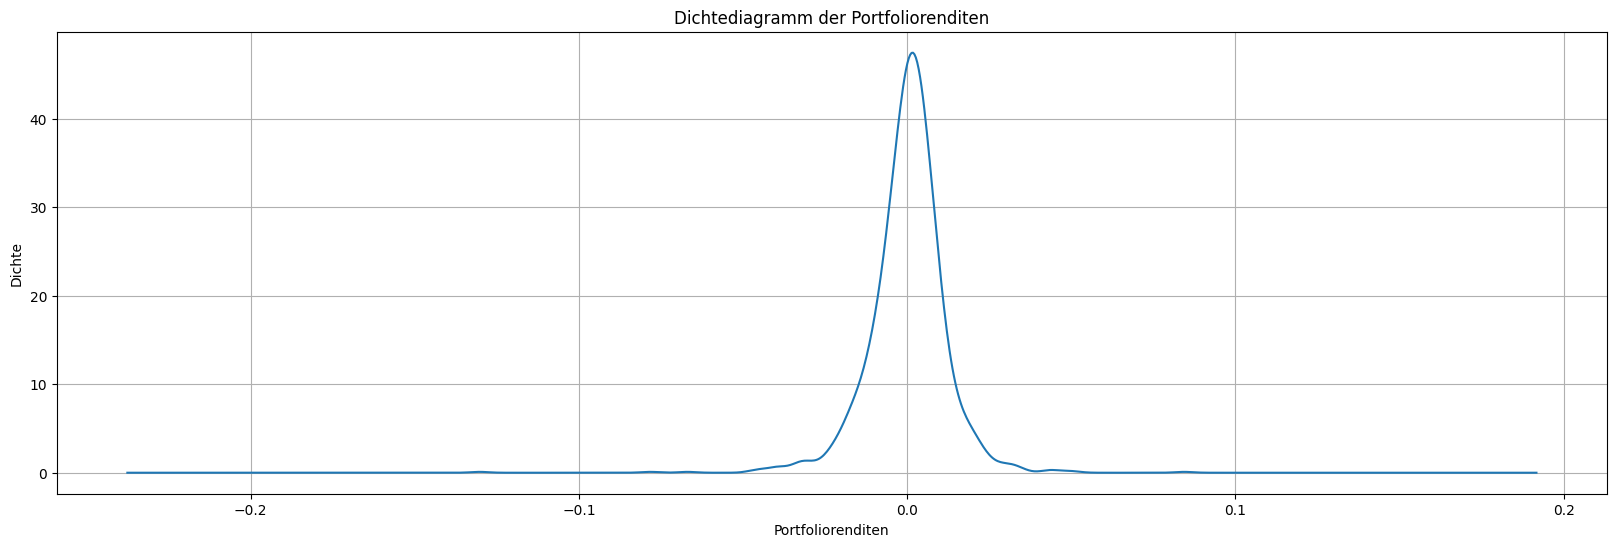

In [9]:
portfolio_returns = returns.dot(weights)
plt.figure(figsize=(20, 6))
portfolio_returns.plot(kind='density', title='Dichtediagramm der Portfoliorenditen')
plt.xlabel('Portfoliorenditen')
plt.ylabel('Dichte')
plt.grid(True)
plt.show()

In [10]:
pf_stats = portfolio_returns.describe()
skewness = portfolio_returns.skew()
kurtosis = portfolio_returns.kurtosis()

# Erstellen eines DataFrame mit den Ergebnissen
stats = {
    'Mean': pf_stats['mean'],
    'Median': pf_stats['50%'],
    'Min': pf_stats['min'],
    'Max': pf_stats['max'],
    'Std Dev': pf_stats['std'],
    'Skewness': skewness,
    'Kurtosis': kurtosis
}

stats_df = pd.DataFrame(stats, index=['Portfolio Returns']).T
print(stats_df)

          Portfolio Returns
Mean               0.000134
Median             0.000868
Min               -0.130253
Max                0.084367
Std Dev            0.011763
Skewness          -1.154633
Kurtosis          14.722286


In [11]:
import scipy.stats as stats
#prüfe auf Normalität
jb_test_stat, jb_p_value = stats.jarque_bera(portfolio_returns)

# Signifikanzniveau
alpha = 0.1

# Testresultate
normality = jb_p_value > alpha
# Ausgabe der Jarque-Bera Testresultate
print(f"Jarque-Bera Teststatistik: {jb_test_stat}")
print(f"p-Wert: {jb_p_value:.3f}")

Jarque-Bera Teststatistik: 13929.877484752798
p-Wert: 0.000


In [12]:
from statsmodels.tsa.stattools import kpss
# KPSS-Test durchführen
result = kpss(portfolio_returns, regression='c', nlags="auto")
# Ergebnisse ausgeben
print('KPSS Teststatistik: ', result[0])
print('p-Wert: ', result[1])
print('Anzahl der Lags: ', result[2])
print('Kritische Werte:')
for key, value in result[3].items():
    print(f'   {key}: {value}')

KPSS Teststatistik:  0.033815547738520225
p-Wert:  0.1
Anzahl der Lags:  13
Kritische Werte:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


/var/folders/jy/7rnm660j0cldg_hs_8fy_j_w0000gp/T/ipykernel_42793/2582768693.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(portfolio_returns, regression='c', nlags="auto")


In [13]:
#Auch mit Log.Transformation werden die Daten nicht normalverteilt. 
log_returns = np.log1p(portfolio_returns)

# Überprüfen der Normalverteilung der transformierten Renditen
jb_test_stat, jb_p_value = stats.jarque_bera(log_returns)
print(f"Jarque-Bera Teststatistik (Log-Returns): {jb_test_stat:.3f}")
print(f"p-Wert (Log-Returns): {jb_p_value:.3f}")

Jarque-Bera Teststatistik (Log-Returns): 19373.891
p-Wert (Log-Returns): 0.000


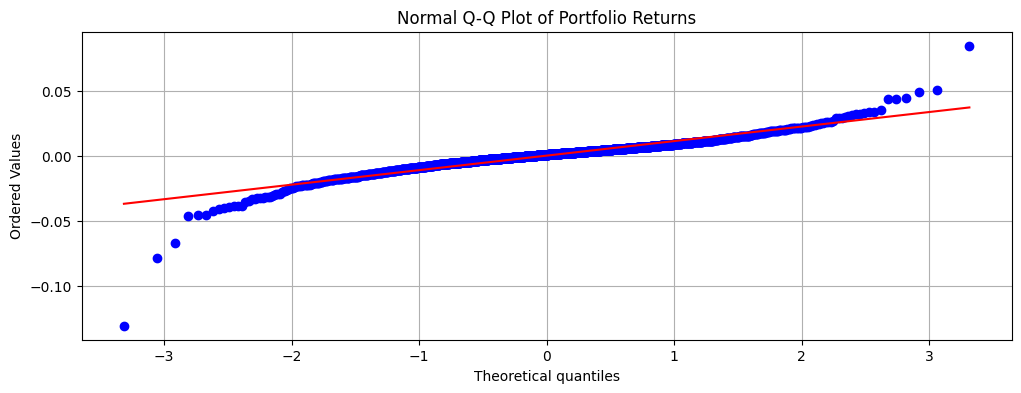

In [14]:
# Erstellen eines Normal-QQ-Plots
plt.figure(figsize=(12, 4))
stats.probplot(portfolio_returns, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot of Portfolio Returns')
plt.grid(True)
plt.show()

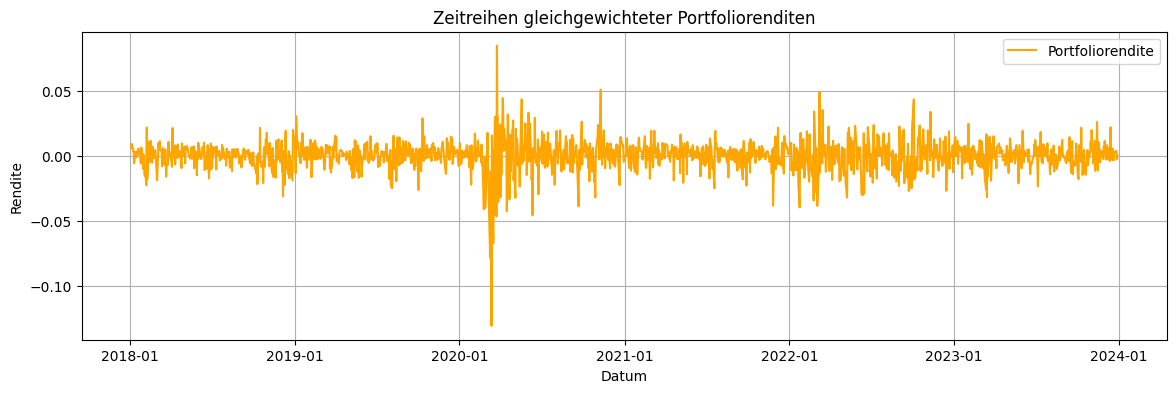

In [15]:
# Plotten der Zeitreihe
portfolio_returns.index = pd.to_datetime(portfolio_returns.index)
plt.figure(figsize=(14, 4))
plt.plot(portfolio_returns.index, portfolio_returns, label='Portfoliorendite', color='orange')

# Anpassen der X-Achse, um nur die Januar-Daten zu zeigen
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel('Datum')
plt.ylabel('Rendite')
plt.title('Zeitreihen gleichgewichteter Portfoliorenditen')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
portfolio_returns

Datum
2018-01-03    0.006132
2018-01-04    0.008413
2018-01-05    0.009044
2018-01-08    0.003315
2018-01-09    0.003646
                ...   
2023-12-21   -0.003378
2023-12-22    0.002365
2023-12-27    0.003880
2023-12-28   -0.002735
2023-12-29    0.000145
Length: 1516, dtype: float64

In [17]:
#VaR Konfidenzniveau
pVaR = [0.999,0.99,0.95]
zScore = norm.ppf(pVaR)
#Definiere VaR-Vektoren
normalVaR = np.zeros(testWindowSize)
shrinkageVaR = np.zeros(testWindowSize)
#Definiere Delta 
delta = np.ones(564)

***Shrinkage Constant Correllationsmatrix***


In [18]:

def covCor(Y,k = None):
    
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned
    
    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
   
    #default setting
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #trừ đi giá trị trung bình của mỗi cột. Y_neu= Y-Y_bar
        k = 1

    #vars
    n = N-k                                    # adjust effective sample size

    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    
    # compute shrinkage target
    samplevar = np.diag(sample.to_numpy())
    sqrtvar = pd.DataFrame(np.sqrt(samplevar))
    rBar = (np.sum(np.sum(sample.to_numpy()/np.matmul(sqrtvar.to_numpy(),sqrtvar.T.to_numpy())))-p)/(p*(p-1)) # mean correlation
    target = pd.DataFrame(rBar*np.matmul(sqrtvar.to_numpy(),sqrtvar.T.to_numpy()))
    target[np.logical_and(np.eye(p),np.eye(p))] = sample[np.logical_and(np.eye(p),np.eye(p))];
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    pihat = sum(piMat.sum())
    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # diagonal part of the parameter that we call rho 
    rho_diag =  np.sum(np.diag(piMat))
    
    # off-diagonal part of the parameter that we call rho 
    term1 = pd.DataFrame(np.matmul((Y**3).T.to_numpy(),Y.to_numpy())/n)
    term2 = pd.DataFrame(np.transpose(mt.repmat(samplevar,p,1))*sample)
    thetaMat = term1-term2
    thetaMat[np.logical_and(np.eye(p),np.eye(p))] = pd.DataFrame(np.zeros((p,p)))[np.logical_and(np.eye(p),np.eye(p))]
    rho_off = rBar*(np.matmul((1/sqrtvar).to_numpy(),sqrtvar.T.to_numpy())*thetaMat).sum().sum()
    
    # compute shrinkage intensity
    rhohat = rho_diag + rho_off
    kappahat = (pihat - rhohat) / gammahat
    shrinkage = max(0 , min(1 , kappahat/n))
    
    # compute shrinkage estimator
    sigmahat = shrinkage*target + (1-shrinkage) * sample;
    
    return shrinkage, sigmahat





In [19]:
# normalPortfolioSigmas = pd.DataFrame()
# daily_normalVaR = pd.DataFrame()
# normalVaR_250 = pd.DataFrame()
# daily_shrinkageVaR = pd.DataFrame()
# shrinkageVaR_250 = pd.DataFrame()
# portfolioGewinnVerlust = pd.DataFrame()
# rolling_250day_returns = pd.DataFrame()
# rolling_daily_returns = pd.DataFrame()
# # Store shrinkage values and sigmahat matrices
# shrinkage_constant_values = []
# lw = LedoitWolf()
# #sigmahat_matrices = []
# for t in range(testWindowSize):
#     k = windowSize + t

#     # Berechnen der Kovarianzmatrix
#     returnsData = returns[t:k].reset_index(drop=True)
#     N,p = returnsData.shape       
#     mean = returnsData.mean(axis=0)
#     Y = returnsData.sub(mean, axis=1)                               #trừ đi giá trị trung bình của mỗi cột. Y_neu= Y-Y_bar
    

#     #vars
#     n = N-1                                   # adjust effective sample size

#     #Cov df: sample covariance matrix
#     sample_cov  = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n    
#     covMatrix = sample_cov

#     #shrinkage_constant, shrinkage_cov = covCor(returnsData)
#     lw.fit(returnsData)
#     shrinkage_cov = lw.covariance_
#     shrinkage_constant = lw.shrinkage_
#     shrinkage_constant_values.append(shrinkage_constant)
#     v= weights
#     v_trans = v.T
    
#     # Berechne Stichproben-VKM sigma 
#     sigma = np.sqrt(v_trans@covMatrix@v)
#     normalPortfolioSigmas.loc[t,'Sigma'] = sigma
#     # Berechne Shrinkage-VKA
#     sigmahat = np.sqrt(v_trans@shrinkage_cov@v)
#     #print(sigmahat.shape)
#     # Speichere der täglicher VaR mit normalen VKM
#     daily_normalVaR.loc[t,'GV'] = -zScore * sigma 
#     daily_shrinkageVaR.loc[t,'GV'] = -zScore * sigmahat 
#     # Speichere der 250day_VaR
#     normalVaR_250.loc[t,'GV'] = -zScore * sigma * np.sqrt(250) 
#     shrinkageVaR_250.loc[t,'GV'] = -zScore * sigmahat * np.sqrt(250) 
#     # Speichere die Gewinn-Verlust-Werte
#     #portfolioGewinnVerlust.loc[t,'GV'] = np.sum(returns.iloc[k, :] * v1)
#     rolling_daily_returns.loc[t,'GV'] = np.sum(returns.iloc[k, :]*weights)
# daily_normalVaR.index = pd.date_range(start='2019-01-02', periods=len(daily_normalVaR), freq='B')
# daily_shrinkageVaR.index = pd.date_range(start='2019-01-02', periods=len(daily_shrinkageVaR), freq='B')

# plt.figure(figsize=(14, 8))
# plt.plot(daily_normalVaR.index, -daily_normalVaR, label='Stichproben-VaR')
# plt.plot(daily_shrinkageVaR.index, -daily_shrinkageVaR, label='Shrinkage-VaR', color='red')
# plt.xlabel('Datum')
# plt.ylabel('VaR')
# plt.title('Schätzung des VaRs zum 99.9%-Konfidenzniveau')
# plt.legend()
# plt.show()


In [20]:
def compare_covariance_matrices(sample_cov, shrinkage_cov):
    results = {}

  # Perform PCA on each covariance matrix
    pca_sample = PCA()
    pca_sample.fit(sample_cov)

    pca_shrinkage = PCA()
    pca_shrinkage.fit(shrinkage_cov)

  # Get eigenvalues and eigenvectors for each PCA
    results['sample_eigenvalues'] = pca_sample.explained_variance_
    results['sample_eigenvectors'] = pca_sample.components_

    results['shrinkage_eigenvalues'] = pca_shrinkage.explained_variance_
    results['shrinkage_eigenvectors'] = pca_shrinkage.components_

    # Calculate Frobenius distance
    frobenius_distance = np.linalg.norm(sample_cov - shrinkage_cov, 'fro')
    results['frobenius_distance'] = frobenius_distance

    return results


In [21]:
normalPortfolioSigmas = pd.DataFrame()
daily_shrinkageVaR_999 = pd.DataFrame()
daily_normalVaR_999 = pd.DataFrame()
shrinkageVaR999_250 = pd.DataFrame()
normalVaR999_250 = pd.DataFrame()

daily_shrinkageVaR_95 = pd.DataFrame()
daily_normalVaR_95 = pd.DataFrame()
shrinkageVaR95_250 = pd.DataFrame()
normalVaR95_250 = pd.DataFrame()

daily_shrinkageVaR_99 = pd.DataFrame()
daily_normalVaR_99 = pd.DataFrame()
shrinkageVaR99_250 = pd.DataFrame()
normalVaR99_250 = pd.DataFrame()

rolling_daily_returns_cor = pd.DataFrame()
# Store shrinkage values and sigmahat matrices
shrinkage_constant_values = []
# Danh sách để lưu trữ kết quả
frobenius_distance_values = []
# returns = np.log1p(returns)
#sigmahat_matrices = []
for t in range(testWindowSize):
    k = windowSize + t

    # Berechnen der Kovarianzmatrix
    
    returnsData = returns[t:k].reset_index(drop=True)
    N,p = returnsData.shape       
    mean = returnsData.mean(axis=0)
    Y = returnsData.sub(mean, axis=1)                               #trừ đi giá trị trung bình của mỗi cột. Y_neu= Y-Y_bar
    #k = 1

    #vars
    n = N-1                                    # adjust effective sample size

    #Cov df: sample covariance matrix
    sample_cov  = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n    
    #sample_cov = pd.DataFrame(np.matmul(returnsData.T.to_numpy(),returnsData.to_numpy()))/249
    #popular_cov = np.cov(returnsData, rowvar=False)
    covMatrix = sample_cov

    shrinkage_constant, shrinkage_cov = covCor(returnsData)
    shrinkage_constant_values.append(shrinkage_constant)
    # lw.fit(returnsData)
    # shrinkage_cov = lw.covariance_
    # shrinkage_constant = lw.shrinkage_
    
    v= weights
    v_trans = v.T
    
    # Berechne Stichproben-VKM sigma 
    sigma = np.sqrt(v_trans@covMatrix@v)
    normalPortfolioSigmas.loc[t,'Sigma'] = sigma
    # Berechne Shrinkage-VKA
    sigmahat = np.sqrt(v_trans@shrinkage_cov@v)
    #print(sigmahat.shape)
    # Speichere der täglicher VaR mit normalen VKM
    daily_normalVaR_999.loc[t,'GV'] = -zScore[0] * sigma 
    daily_shrinkageVaR_999.loc[t,'GV'] = -zScore[0] * sigmahat 

    daily_normalVaR_99.loc[t,'GV'] = -zScore[1] * sigma 
    daily_shrinkageVaR_99.loc[t,'GV'] = -zScore[1] * sigmahat 

    daily_normalVaR_95.loc[t,'GV'] = -zScore[2] * sigma 
    daily_shrinkageVaR_95.loc[t,'GV'] = -zScore[2] * sigmahat 
    # Speichere der 250day_VaR

    normalVaR999_250.loc[t,'GV'] = -zScore[0] * sigma * np.sqrt(250) 
    shrinkageVaR999_250.loc[t,'GV'] = -zScore[0] * sigmahat * np.sqrt(250) 

    normalVaR99_250.loc[t,'GV'] = -zScore[1] * sigma * np.sqrt(250) 
    shrinkageVaR99_250.loc[t,'GV'] = -zScore[1] * sigmahat * np.sqrt(250)

    normalVaR95_250.loc[t,'GV'] = -zScore[2] * sigma * np.sqrt(250) 
    shrinkageVaR95_250.loc[t,'GV'] = -zScore[2] * sigmahat * np.sqrt(250)
    # Speichere die Gewinn-Verlust-Werte
    #portfolioGewinnVerlust.loc[t,'GV'] = np.sum(returns.iloc[k, :] * v1)
    rolling_daily_returns_cor.loc[t,'GV'] = np.sum(returns.iloc[k, :]*weights)

    # Tính khoảng cách Frobenius
    frobenius_distance = np.linalg.norm(sample_cov - shrinkage_cov, 'fro')
    frobenius_distance_values.append(frobenius_distance)



Erster Eintrag im Index von daily_normalVaR: 2019-01-02 00:00:00
Letzter Eintrag im Index von daily_normalVaR: 2023-12-29 00:00:00
Erster Eintrag im Index von daily_shrinkageVaR: 2019-01-02 00:00:00
Letzter Eintrag im Index von daily_shrinkageVaR: 2023-12-29 00:00:00


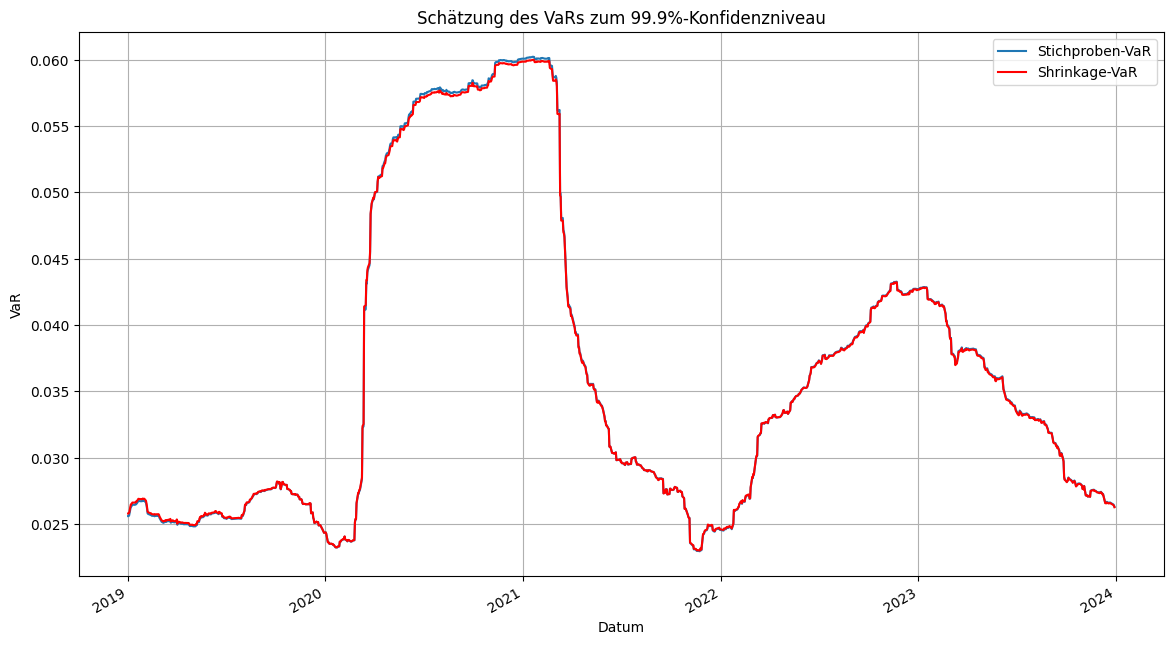

In [23]:
# Sicherstellen, dass die Indizes als datetime interpretiert werden
daily_normalVaR_999.index = pd.to_datetime(returns.index[250:250 + len(daily_normalVaR_999)])
daily_shrinkageVaR_999.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_999)])

# Überprüfen des neuen Indexes von daily_normalVaR und daily_shrinkageVaR
print("Erster Eintrag im Index von daily_normalVaR:", daily_normalVaR_999.index[0])
print("Letzter Eintrag im Index von daily_normalVaR:", daily_normalVaR_999.index[-1])
print("Erster Eintrag im Index von daily_shrinkageVaR:", daily_shrinkageVaR_999.index[0])
print("Letzter Eintrag im Index von daily_shrinkageVaR:", daily_shrinkageVaR_999.index[-1])

# Plotten des Subsets mit Beschriftung der X-Achse auf Jahre reduziert
plt.figure(figsize=(14, 8))
plt.plot(daily_normalVaR_999.index, -daily_normalVaR_999, label='Stichproben-VaR')
plt.plot(daily_shrinkageVaR_999.index, -daily_shrinkageVaR_999, label='Shrinkage-VaR', color='red')

# X-Achse formatieren, um nur Jahre anzuzeigen
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.YearLocator()))

# Verbesserung der Darstellung der X-Achse
plt.gcf().autofmt_xdate()

# Titel und Labels hinzufügen
plt.xlabel('Datum')
plt.ylabel('VaR')
plt.title('Schätzung des VaRs zum 99.9%-Konfidenzniveau')
plt.legend()
plt.grid(True)
plt.show()




In [25]:
pd.Series(frobenius_distance_values).describe()

count    1266.000000
mean        0.012567
std         0.010061
min         0.005025
25%         0.006312
50%         0.008672
75%         0.009716
max         0.038707
dtype: float64

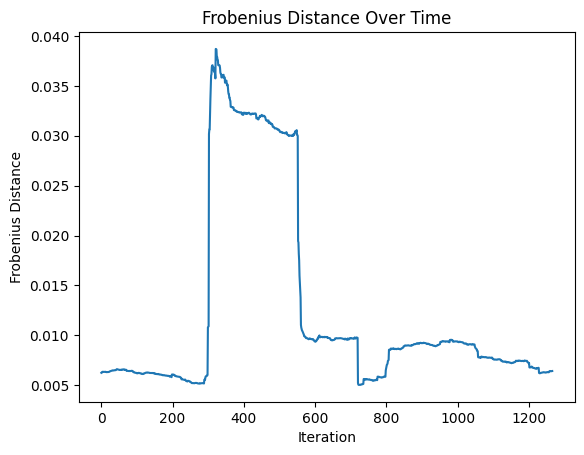

In [26]:
# Vẽ biểu đồ khoảng cách Frobenius (ví dụ)
plt.plot(frobenius_distance_values)
plt.xlabel('Iteration')
plt.ylabel('Frobenius Distance')
plt.title('Frobenius Distance Over Time')
plt.show()


In [27]:
n = 1266
# Wahrscheinlichkeit eines Verlusts an einem Tag
p = 0.01

# 95% Quantile der Binomialverteilung
threshold = stats.binom.ppf(0.999, n, p)
threshold


25.0

1266


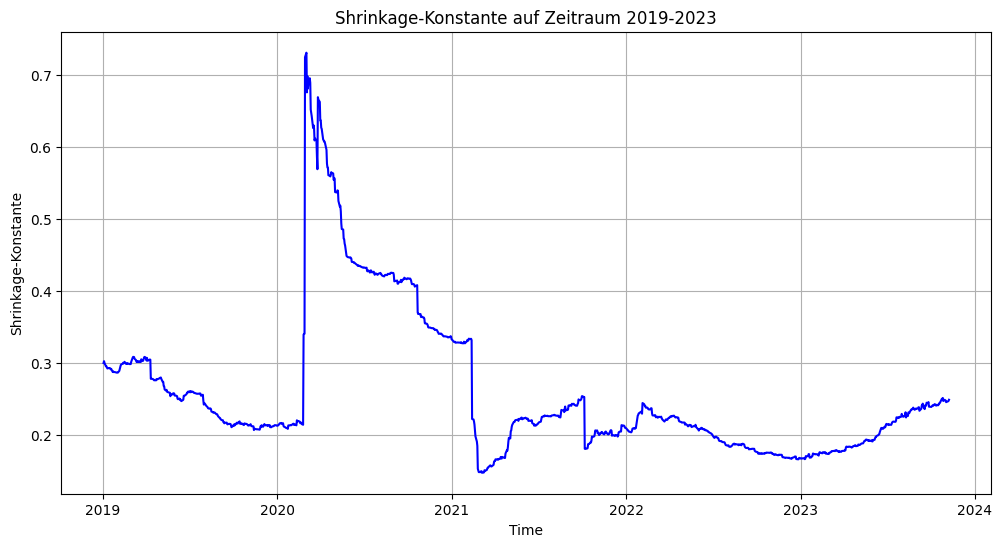

In [28]:
# Convert shrinkage values and sigmahat matrices to a DataFrame
df_shrinkage = pd.DataFrame({'Shrinkage-Konstant': shrinkage_constant_values})
df_shrinkage.index = pd.date_range(start='2019-01-02', periods=len(df_shrinkage), freq='B')
print(len(df_shrinkage))
plt.figure(figsize=(12, 6))
plt.plot(df_shrinkage.index, df_shrinkage['Shrinkage-Konstant']
         , linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Shrinkage-Konstante')
plt.title('Shrinkage-Konstante auf Zeitraum 2019-2023')
plt.grid(True)
plt.show()

TypeError: Cannot pass DataFrame to 'pandas.array'

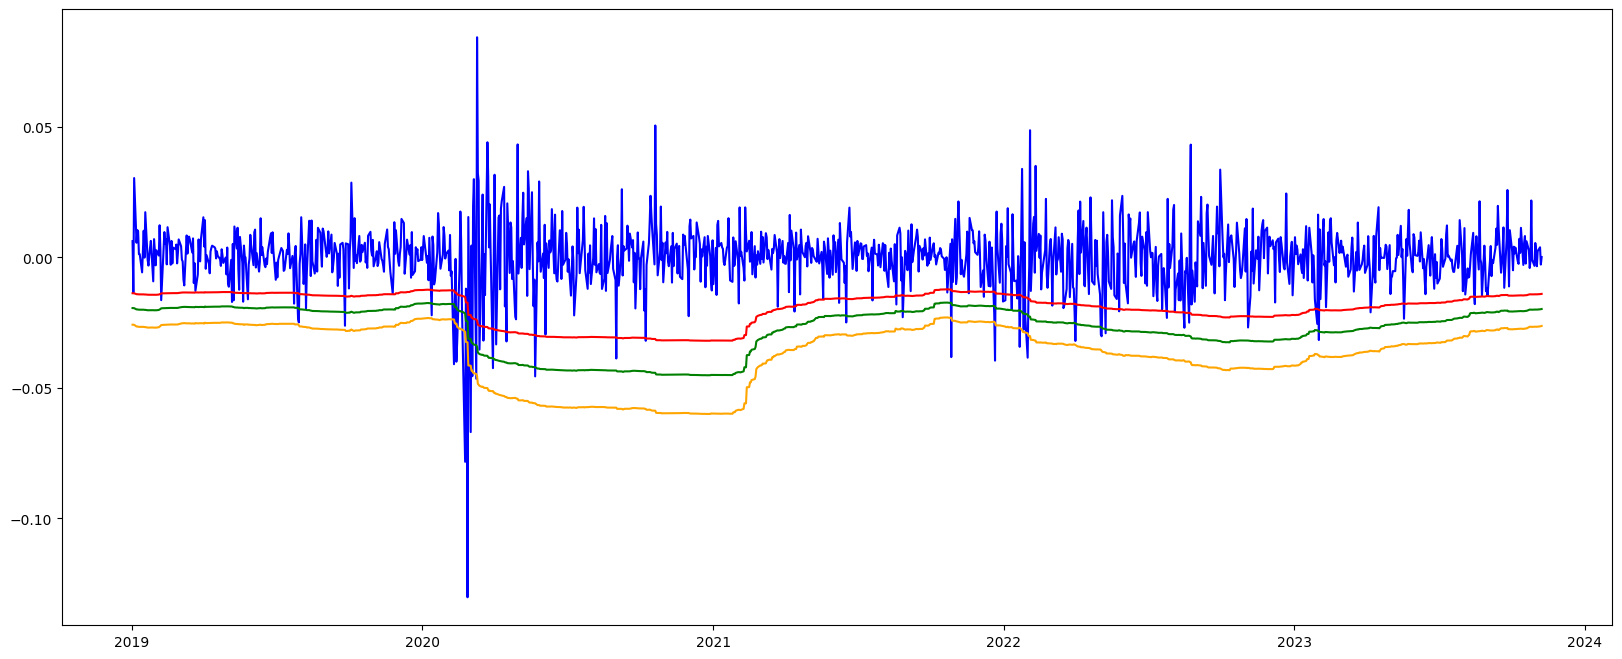

In [31]:
daily_shrinkageVaR_95.index = pd.date_range(start='2019-01-02', periods=len(daily_shrinkageVaR_95), freq='B')
daily_shrinkageVaR_99.index = pd.date_range(start='2019-01-02', periods=len(daily_shrinkageVaR_99), freq='B')
daily_shrinkageVaR_999.index = pd.date_range(start='2019-01-02', periods=len(daily_shrinkageVaR_999), freq='B')
rolling_daily_returns_cor.index = pd.date_range(start='2019-01-02', periods=len(rolling_daily_returns_cor), freq='B')
# Finden der Überschreitungen
exceeds_shrinkageVaR_95 = rolling_daily_returns_cor['GV'] < daily_shrinkageVaR_95['GV']
exceeds_shrinkageVaR_99 = rolling_daily_returns_cor['GV'] < daily_shrinkageVaR_99['GV']
exceeds_shrinkageVaR_999 = rolling_daily_returns_cor['GV'] < daily_shrinkageVaR_999['GV']
# Plotten der VaR-Werte und der Portfoliorenditen ab dem 2. Januar 2019
plt.figure(figsize=(20, 8))
plt.plot(rolling_daily_returns_cor.index, rolling_daily_returns_cor, label='Portfoliorendite', color='blue')
plt.plot(daily_shrinkageVaR_95.index, daily_shrinkageVaR_95, label='VaR 95%', color='red')
plt.plot(daily_shrinkageVaR_99.index, daily_shrinkageVaR_99, label='VaR 99%', color='green')
plt.plot(daily_shrinkageVaR_999.index, daily_shrinkageVaR_999, label='VaR 99.9%', color='orange')


# Schwarze Punkte für Überschreitungen plotten
plt.scatter(rolling_daily_returns_cor.index[daily_shrinkageVaR_95], rolling_daily_returns_cor[exceeds_shrinkageVaR_95], color='black', marker='o', label='Exceeds Shrinkage VaR 90%')
plt.scatter(rolling_daily_returns_cor.index[daily_shrinkageVaR_99], rolling_daily_returns_cor[exceeds_shrinkageVaR_99], color='red', marker='x', label='Exceeds Shrinkage VaR 95%')
plt.scatter(rolling_daily_returns_cor.index[daily_shrinkageVaR_999], rolling_daily_returns_cor[exceeds_shrinkageVaR_999], color='green', marker='+', label='Exceeds Shrinkage VaR 99.9%')
# Sicherstellen, dass die Indizes als datetime interpretiert werden

daily_shrinkageVaR_95.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_95)])
daily_shrinkageVaR_99.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_99)])
daily_shrinkageVaR_999.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_999)])
rolling_daily_returns_cor.index = pd.to_datetime(returns.index[250:250 + len(rolling_daily_returns_cor)])
# Überprüfen des neuen Indexes von daily_normalVaR und daily_shrinkageVaR
print("Erster Eintrag im Index von daily_shrinkageVaR:", daily_shrinkageVaR_999.index[0])
print("Letzter Eintrag im Index von daily_shrinkageVaR:", daily_shrinkageVaR_999.index[-1])



# X-Achse formatieren, um nur Jahre anzuzeigen
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.YearLocator()))

# Verbesserung der Darstellung der X-Achse
plt.gcf().autofmt_xdate()

plt.xlabel('Datum')
plt.ylabel('Werte')
plt.title('Backtesting Shrinkage-VaR')
plt.legend()
plt.grid(True)
plt.show()

Erster Eintrag im Index von daily_shrinkageVaR_95: 2019-01-02 00:00:00
Letzter Eintrag im Index von daily_shrinkageVaR_95: 2023-12-29 00:00:00


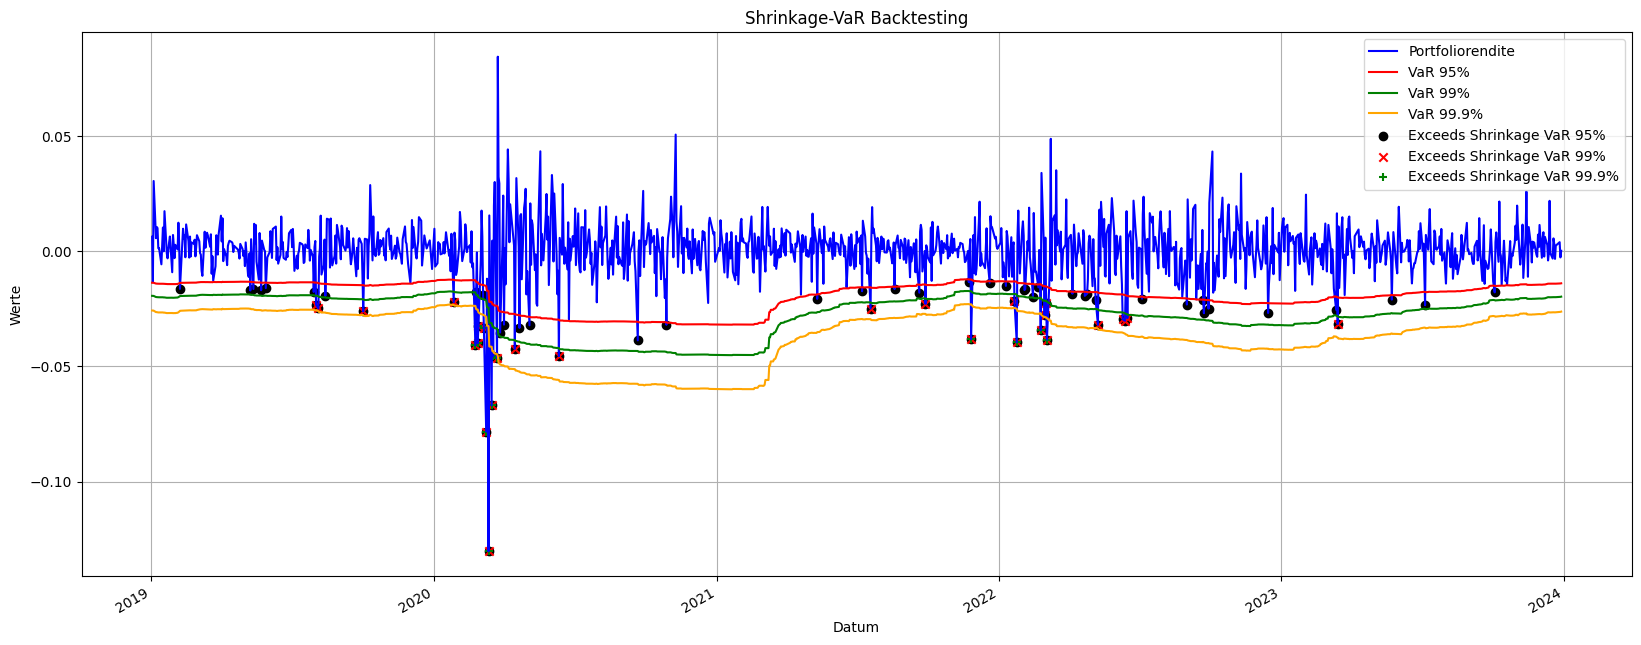

In [33]:
# Sicherstellen, dass die Indizes als datetime interpretiert werden
daily_shrinkageVaR_95.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_95)])
daily_shrinkageVaR_99.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_99)])
daily_shrinkageVaR_999.index = pd.to_datetime(returns.index[250:250 + len(daily_shrinkageVaR_999)])
rolling_daily_returns_cor.index = pd.to_datetime(returns.index[250:250 + len(rolling_daily_returns_cor)])

# Finden der Überschreitungen
exceeds_shrinkageVaR_95 = rolling_daily_returns_cor['GV'] < daily_shrinkageVaR_95['GV']
exceeds_shrinkageVaR_99 = rolling_daily_returns_cor['GV'] < daily_shrinkageVaR_99['GV']
exceeds_shrinkageVaR_999 = rolling_daily_returns_cor['GV'] < daily_shrinkageVaR_999['GV']

# Plotten der VaR-Werte und der Portfoliorenditen ab dem 2. Januar 2019
plt.figure(figsize=(20, 8))
plt.plot(rolling_daily_returns_cor.index, rolling_daily_returns_cor['GV'], label='Portfoliorendite', color='blue')
plt.plot(daily_shrinkageVaR_95.index, daily_shrinkageVaR_95['GV'], label='VaR 95%', color='red')
plt.plot(daily_shrinkageVaR_99.index, daily_shrinkageVaR_99['GV'], label='VaR 99%', color='green')
plt.plot(daily_shrinkageVaR_999.index, daily_shrinkageVaR_999['GV'], label='VaR 99.9%', color='orange')

# Schwarze Punkte für Überschreitungen plotten
plt.scatter(rolling_daily_returns_cor.index[exceeds_shrinkageVaR_95], rolling_daily_returns_cor['GV'][exceeds_shrinkageVaR_95], color='black', marker='o', label='Exceeds Shrinkage VaR 95%')
plt.scatter(rolling_daily_returns_cor.index[exceeds_shrinkageVaR_99], rolling_daily_returns_cor['GV'][exceeds_shrinkageVaR_99], color='red', marker='x', label='Exceeds Shrinkage VaR 99%')
plt.scatter(rolling_daily_returns_cor.index[exceeds_shrinkageVaR_999], rolling_daily_returns_cor['GV'][exceeds_shrinkageVaR_999], color='green', marker='+', label='Exceeds Shrinkage VaR 99.9%')

# Überprüfen des neuen Indexes von daily_normalVaR und daily_shrinkageVaR
print("Erster Eintrag im Index von daily_shrinkageVaR_95:", daily_shrinkageVaR_95.index[0])
print("Letzter Eintrag im Index von daily_shrinkageVaR_95:", daily_shrinkageVaR_95.index[-1])

# X-Achse formatieren, um nur Jahre anzuzeigen
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.YearLocator()))

# Verbesserung der Darstellung der X-Achse
plt.gcf().autofmt_xdate()

plt.xlabel('Datum')
plt.ylabel('Werte')
plt.title('Shrinkage-VaR Backtesting')
plt.legend()
plt.grid(True)
plt.show()

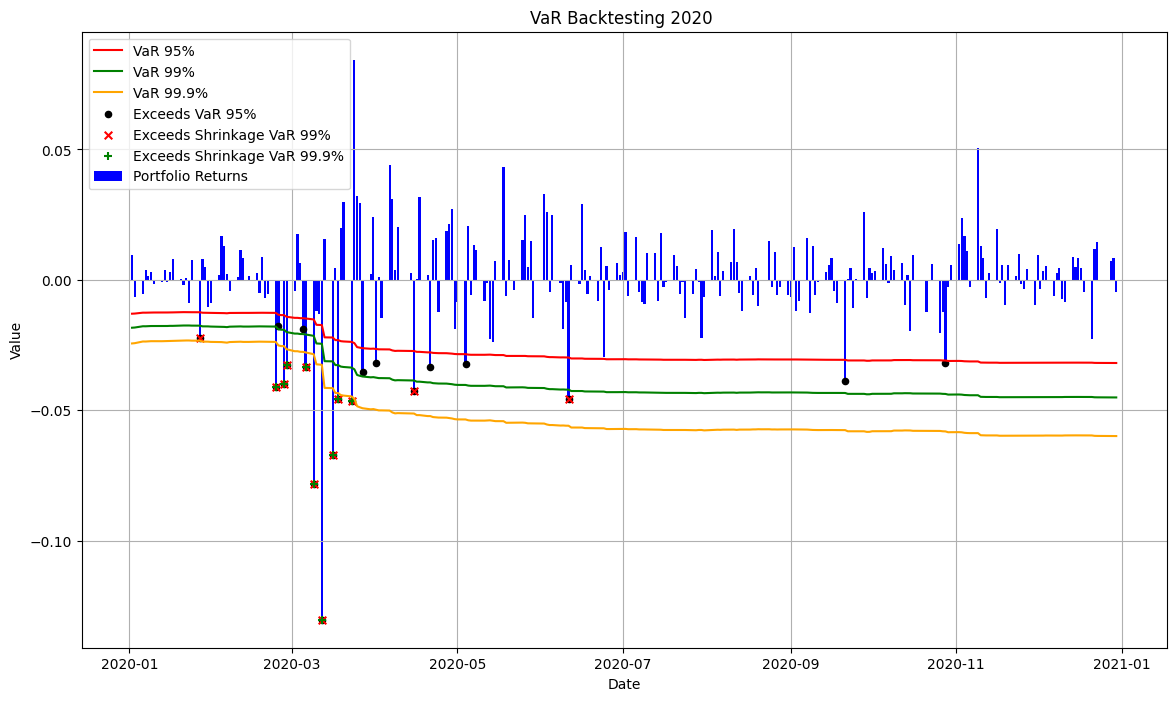

In [34]:
# Zeitraum mit großen Änderungen identifizieren (z.B. März 2020)
start_zoom_date = '2020-01-02'
end_zoom_date = '2020-12-30'

# Daten filtern
zoom_daily_shrinkageVaR_95 = daily_shrinkageVaR_95.loc[start_zoom_date:end_zoom_date]
zoom_daily_shrinkageVaR_99= daily_shrinkageVaR_99.loc[start_zoom_date:end_zoom_date]
zoom_daily_shrinkageVaR_999 = daily_shrinkageVaR_999.loc[start_zoom_date:end_zoom_date]
zoom_rolling_daily_returns = rolling_daily_returns_cor.loc[start_zoom_date:end_zoom_date]
zoom_exceeds_shrinkageVaR_95 = exceeds_shrinkageVaR_95.loc[start_zoom_date:end_zoom_date]
zoom_exceeds_shrinkageVaR_99 = exceeds_shrinkageVaR_99.loc[start_zoom_date:end_zoom_date]
zoom_exceeds_shrinkageVaR_999 = exceeds_shrinkageVaR_999.loc[start_zoom_date:end_zoom_date]

# Plotten der gefilterten Werte
plt.figure(figsize=(14, 8))
plt.bar(zoom_rolling_daily_returns.index, zoom_rolling_daily_returns['GV'], label='Portfolio Returns', color='blue')
plt.plot(zoom_daily_shrinkageVaR_95.index, zoom_daily_shrinkageVaR_95, label='VaR 95%', color='red')
plt.plot(zoom_daily_shrinkageVaR_99.index, zoom_daily_shrinkageVaR_99, label='VaR 99%', color='green')
plt.plot(zoom_daily_shrinkageVaR_99.index, zoom_daily_shrinkageVaR_999, label='VaR 99.9%', color='orange')

# Schwarze Punkte für Überschreitungen plotten
plt.scatter(zoom_rolling_daily_returns.index[zoom_exceeds_shrinkageVaR_95], zoom_rolling_daily_returns[zoom_exceeds_shrinkageVaR_95], color='black', marker='o',s=20, label='Exceeds VaR 95%')
plt.scatter(zoom_rolling_daily_returns.index[zoom_exceeds_shrinkageVaR_99], zoom_rolling_daily_returns[zoom_exceeds_shrinkageVaR_99], color='red', marker='x',s=30, label='Exceeds Shrinkage VaR 99%')
plt.scatter(zoom_rolling_daily_returns.index[zoom_exceeds_shrinkageVaR_999], zoom_rolling_daily_returns[zoom_exceeds_shrinkageVaR_999], color='green', marker='+',s=30, label='Exceeds Shrinkage VaR 99.9%')


plt.xlabel('Date')
plt.ylabel('Value')
plt.title('VaR Backtesting 2020 ')
plt.legend()
plt.grid(True)
plt.show()

***Backtesting***

In [35]:
from scipy.stats import binom, chi2, kstest

In [37]:
# Define backtesting functions
def kupiec_pof_test(returns, var, alpha):
    # Step 1: Calculate the number of exceptions
    exceptions = returns < var
    num_exceptions = np.sum(exceptions)
    num_observations = len(returns)
    
    # Step 2: Calculate the test statistic
    p_hat = num_exceptions / num_observations
    test_stat = -2 * (num_observations * np.log(1 - alpha) +
                      num_exceptions * np.log(alpha / (1 - alpha)) -
                      (num_observations * np.log(1 - p_hat) + num_exceptions * np.log(p_hat / (1 - p_hat))))
    
    # Step 3: Calculate the p-value
    p_value = 1 - stats.chi2.cdf(test_stat, df=1)
    return num_exceptions, p_value
def christoffersen_cc_test(portfolio_returns, var_estimates, confidence_level):
    exceptions = portfolio_returns < var_estimates
    num_exceptions = np.sum(exceptions)
    num_days = len(portfolio_returns)
    expected_exceptions = num_days * (1 - confidence_level)
    transition_matrix = np.zeros((2, 2))
    for i in range(1, len(exceptions)):
        transition_matrix[exceptions[i - 1], exceptions[i]] += 1
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
    p_independence = (transition_matrix[0, 1] * transition_matrix[1, 0]) / (
            (1 - transition_matrix[0, 0]) * (1 - transition_matrix[1, 1]))
    lr_independence = -2 * np.log(p_independence)
    p_value = 1 - chi2.cdf(lr_independence, df=1)
    return num_exceptions, expected_exceptions, p_value

# Assuming df, returns, weights, zScore, testWindowSize, and windowSize are already defined


In [38]:
# Perform backtesting-NormalVaR
alpha = [0.05,0.01,0.001]

# Kupiec's Proportion of Failures (POF) Test
num_exceptions, p_value_pof = kupiec_pof_test(rolling_daily_returns_cor['GV'], daily_shrinkageVaR_95['GV'], alpha[0])
print(f'Kupiec POF Test - Anzahl der Überschreitungen: {num_exceptions}, P-value: {p_value_pof}, Alpha: {alpha[0]}')
num_exceptions, p_value_pof = kupiec_pof_test(rolling_daily_returns_cor['GV'], daily_shrinkageVaR_99['GV'], alpha[1])
print(f'Kupiec POF Test - Anzahl der Überschreitungen: {num_exceptions}, P-value: {p_value_pof}, Alpha: {alpha[1]}')
num_exceptions, p_value_pof = kupiec_pof_test(rolling_daily_returns_cor['GV'], daily_shrinkageVaR_999['GV'], alpha[2])
print(f'Kupiec POF Test - Anzahl der Überschreitungen: {num_exceptions}, P-value: {p_value_pof}, Alpha: {alpha[2]}')

# Christoffersen's Conditional Coverage (CC) Test
#num_exceptions, expected_exceptions, p_value_cc = christoffersen_cc_test(rolling_daily_returns_cor['GV'], daily_normalVaR['GV'], confidence_level)
#print(f'Christoffersen CC Test - Number of exceptions: {num_exceptions}, Expected exceptions: {expected_exceptions}, P-value: {p_value_cc}')


Kupiec POF Test - Number of exceptions: 69, P-value: 0.4684714054240072, Alpha: 0.05
Kupiec POF Test - Number of exceptions: 29, P-value: 7.795853861936042e-05, Alpha: 0.01
Kupiec POF Test - Number of exceptions: 13, P-value: 1.0675234030088632e-09, Alpha: 0.001
